# HRRR Zarr Data Loading Guide

There's a variety of samples script out there for using the HRRR Zarr data. They don't all load the data the same way, and how to load it can be pretty confusing. This guide provides our current (as of writing) recommendations for the "best" ways to access the data, with weight given to performance (speed), code length, and a preference for high-level APIs. In the examples, as much as possible is written as functions that can be copied to your code.

## Basic data model + urls

### Identifying a unique Zarr array in the HRRR Zarr Archive

The data is split into separate Zarr arrays based on the following:

- Model run (identified by datetime)
- Level type:
    - surface ("sfc")
    - pressure ("prs")
- Variable name (including level and parameter short name)
    - see [this table](https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_variables.html)
- Model type:
    - forecast ("fcst")
    - analysis ("anl")

For your use case, many of these values may always be the same. For instance, perhaps there are two variables and other than that only the model run changes. But the functions provided here need to be usable for all cases, so let's create a data class in Python to keep track of these.

In [1]:
import dataclasses
import datetime

@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        if self.model_type == "fcst": 
            # Extra id part since forecasts have an additional (time) dimension
            return "0." + chunk_id
        else:
            return chunk_id

### Identifying a chunk

Each Zarr array is chunked such that every grid point is consistently in the same spot in the same chunk. This allows us to efficiently analyze data at a single grid point or small region without having to load the whole zarr array. This picture shows how the grid is chunked:

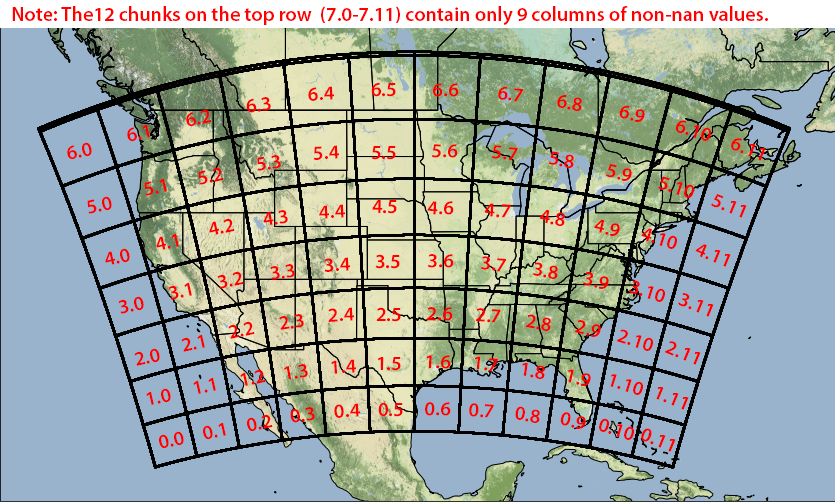

As you can see, the chunk ids have the format \<grid y chunk index\>.\<grid x chunk index\>

### Generating urls

#### For the browser

Browser-ready url to explore data available for a model run:

In [2]:
level_type = "sfc"
model_type = "fcst"
run_hour = datetime.datetime(2021, 1, 1, 7)

def create_hrrr_zarr_explorer_url(level_type, model_type, run_hour):
    url = "https://hrrrzarr.s3.amazonaws.com/index.html"
    url += run_hour.strftime(
        f"#{level_type}/%Y%m%d/%Y%m%d_%Hz_{model_type}.zarr/")
    return url

print(create_hrrr_zarr_explorer_url(level_type, model_type, run_hour))
print(create_hrrr_zarr_explorer_url("prs", "anl", run_hour))

https://hrrrzarr.s3.amazonaws.com/index.html#sfc/20210101/20210101_07z_fcst.zarr/
https://hrrrzarr.s3.amazonaws.com/index.html#prs/20210101/20210101_07z_anl.zarr/


Url to directly download a chunk:

In [3]:
zarr_id = ZarrId(
                run_hour=datetime.datetime(2020, 8, 1, 0), # Aug 1, 0Z
                level_type="sfc",
                var_level="1000mb",
                var_name="TMP",
                model_type="anl"
                )
chunk_id = "4.3"

def create_https_chunk_url(zarr_id, chunk_id):
    url = "https://hrrrzarr.s3.amazonaws.com"
    url += zarr_id.run_hour.strftime(
        f"/{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}/{zarr_id.var_level}/{zarr_id.var_name}"
    url += f"/{zarr_id.format_chunk_id(chunk_id)}"
    return url

create_https_chunk_url(zarr_id, chunk_id)

'https://hrrrzarr.s3.amazonaws.com/sfc/20200801/20200801_00z_anl.zarr/1000mb/TMP/1000mb/TMP/4.3'

#### For use in code

For automated purposes, we improve performance by downloading from the S3 protocol instead of HTTPS. There are three S3 urls we care about that are related to the zarr data format:

- The group url
    - Start of the zarr array data format
    - Includes metadata such as the grid
- The subgroup url
    - Where the actual data variable is stored
    - While subgroups are part of the zarr spec, there's not necessarily a good reason for the data in this case to have this extra level of nesting
- The chunk url
    - Contains just the data for the chunk (no metadata)
    - Current APIs (zarr, xarray) don't support reading zarr data by chunks, so we have to write relatively low-level code to load this data

In [4]:
def create_s3_group_url(zarr_id, prefix=True):
    url = "s3://hrrrzarr/" if prefix else "" # Skip when using boto3
    url += zarr_id.run_hour.strftime(
        f"{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}"
    return url

create_s3_group_url(zarr_id)

's3://hrrrzarr/sfc/20200801/20200801_00z_anl.zarr/1000mb/TMP'

In [5]:
def create_s3_subgroup_url(zarr_id, prefix=True):
    url = create_s3_group_url(zarr_id, prefix)
    url += f"/{zarr_id.var_level}"
    return url

create_s3_subgroup_url(zarr_id)

's3://hrrrzarr/sfc/20200801/20200801_00z_anl.zarr/1000mb/TMP/1000mb'

In [6]:
def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = create_s3_subgroup_url(zarr_id, prefix)
    url += f"/{zarr_id.var_name}/{zarr_id.format_chunk_id(chunk_id)}"
    return url

create_s3_chunk_url(zarr_id, chunk_id)

'sfc/20200801/20200801_00z_anl.zarr/1000mb/TMP/1000mb/TMP/4.3'

## Loading Data

### Use Case 1: Whole grid, one model run

In this case, we recommend using xarray.open_mfdataset. It allows you to load the group with its metadata and the subgroup that contains the actual data variable at the same time.

Note: If you get an error like "CRSError: Invalid datum string", there's a fix for it at the bottom of this page.

In [9]:
import s3fs
import xarray as xr
import metpy

def load_dataset(urls):
    fs = s3fs.S3FileSystem(anon=True)    
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
    
    # add the projection data
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(grid_mapping_name="lambert_conformal_conic", 
                                 longitude_of_central_meridian=-97.5,
                                 latitude_of_projection_origin=38.5,
                                 standard_parallel=38.5)
    ds = ds.metpy.assign_latitude_longitude()    
    return ds

load_dataset([create_s3_group_url(zarr_id), create_s3_subgroup_url(zarr_id)])

<xarray.Dataset>
Dimensions:                  (x: 1799, y: 1059)
Coordinates:
  * x                        (x) float64 -2.698e+06 -2.695e+06 ... 2.696e+06
  * y                        (y) float64 -1.587e+06 -1.584e+06 ... 1.587e+06
    metpy_crs                object Projection: lambert_conformal_conic
    latitude                 (y, x) float64 21.09 21.1 21.1 ... 47.87 47.86
    longitude                (y, x) float64 -122.7 -122.6 ... -61.05 -61.01
Data variables:
    TMP                      (y, x) float16 dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    height                   float64 ...
    pressure                 float64 ...
    time                     datetime64[ns] ...

### Use Case 2: Whole grid, multiple model runs

In this case, it's more performant to use xarray.open_dataset. You call it once on the group url to get the grid data––remember, the geospatial grid's always the same so you can use any model run hour for that part. Then call open_dataset again for every run hour you're interested in.

In [10]:
fs = s3fs.S3FileSystem(anon=True) 

def load(url, run_hour=None, new_time_dimension=None):
    # Download the data from S3. May be lazy.
    ds = xr.open_dataset(s3fs.S3Map(url, s3=fs), engine="zarr")
    
    # Add the model run hour in as a dimension
    if run_hour is not None:
        ds[new_time_dimension] = run_hour
        ds = ds.set_coords(new_time_dimension)
    
    # Later on we use metpy functions that expect the grid variables to be x and y
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    return ds

def load_combined_dataset(zarr_ids):
    
    # Get the grid data (at a long forecast hour in case the whole time dim is needed)
    grid_zarr_id = dataclasses.replace(zarr_ids[0])
    grid_zarr_id.run_hour = grid_zarr_id.run_hour.replace(hour=0)  
    grid = load(create_s3_group_url(grid_zarr_id))
    
    is_forecast = zarr_ids[0].model_type == "fcst"
    new_time_dimension = "run_time" if is_forecast else "time"
    
    datasets = [load(create_s3_subgroup_url(zarr_id), zarr_id.run_hour, new_time_dimension) 
                for zarr_id in zarr_ids]
    
    if is_forecast: # Align the time axes of each dataset (b/c forecasts have different lengths)
        for dataset in datasets:
            dataset["time"] = grid["time"][:len(dataset["time"])]
        datasets = xr.align(*datasets, join="outer")
        
    ds = xr.concat(datasets, dim=new_time_dimension, combine_attrs="override")
    
    # Add the geospatial data to the combined dataset
    ds["x"] = grid["x"]
    ds["y"] = grid["y"]  
    ds = ds.metpy.assign_crs(grid_mapping_name="lambert_conformal_conic", 
                                 longitude_of_central_meridian=-97.5,
                                 latitude_of_projection_origin=38.5,
                                 standard_parallel=38.5)
    ds = ds.metpy.assign_latitude_longitude()
    
    return ds

In [11]:
zarr_ids = [ZarrId(
                run_hour=datetime.datetime(2020, 7, 16, 6) + datetime.timedelta(hours=time_delta),
                level_type="sfc",
                var_level="entire_atmosphere_single_layer",
                var_name="PWAT",
                model_type="fcst"
                )
            for time_delta in range(3)] # get 3 hours starting at the given time

load_combined_dataset(zarr_ids)

<xarray.Dataset>
Dimensions:    (run_time: 3, time: 36, x: 1799, y: 1059)
Coordinates:
  * y          (y) float64 -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
  * x          (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * time       (time) datetime64[ns] 2020-07-16T01:00:00 ... 2020-07-17T12:00:00
  * run_time   (run_time) datetime64[ns] 2020-07-16T06:00:00 ... 2020-07-16T0...
    metpy_crs  object Projection: lambert_conformal_conic
    latitude   (y, x) float64 21.09 21.1 21.1 21.11 ... 47.89 47.88 47.87 47.86
    longitude  (y, x) float64 -122.7 -122.6 -122.6 ... -61.09 -61.05 -61.01
Data variables:
    PWAT       (run_time, time, y, x) float16 40.62 40.62 40.5 ... nan nan nan

### Use Case 3: Gridpoint, multiple model runs

If you're downloading a lot of hours of data and don't need the whole grid, the xarray method will be extremely slow. Instead, the data is chunked based on geospatial location, so you can download only the necessary chunks of the zarr array. Doing this is lower-level and won't decompress or read metadata automatically.

First, we get the chunk index file:

In [12]:
! wget "https://hrrrzarr.s3.amazonaws.com/grid/HRRR_chunk_index.h5"

--2021-06-28 14:12:47--  https://hrrrzarr.s3.amazonaws.com/grid/HRRR_chunk_index.h5
Resolviendo hrrrzarr.s3.amazonaws.com (hrrrzarr.s3.amazonaws.com)... 52.219.116.18
Conectando con hrrrzarr.s3.amazonaws.com (hrrrzarr.s3.amazonaws.com)[52.219.116.18]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 38160716 (36M) [application/x-www-form-urlencoded]
Grabando a: «HRRR_chunk_index.h5.3»

HRRR_chunk_index.h5 100%[===================>]  36.39M  22.0MB/s    en 1.7s    

2021-06-28 14:12:48 (22.0 MB/s) - «HRRR_chunk_index.h5.3» guardado [38160716/38160716]



In [13]:
chunk_index = xr.open_dataset("HRRR_chunk_index.h5", engine="scipy") # Currently only scipy works with this file!
chunk_index

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Coordinates:
  * x           (x) float64 -2.701e+06 -2.698e+06 ... 2.697e+06 2.7e+06
  * y           (y) float64 -1.581e+06 -1.578e+06 ... 1.584e+06 1.587e+06
Data variables:
    chunk_id    (x, y) object ...
    index_x     (x) int32 ...
    chunk_x     (x) int32 ...
    in_chunk_x  (x) int32 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    index_y     (y) int32 ...
    chunk_y     (y) int32 ...
    in_chunk_y  (y) int32 ...

Next, we need to get the nearest point:

In [14]:
import cartopy.crs as ccrs

projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])

def get_nearest_point(projection, chunk_index, longitude, latitude):
    x, y = projection.transform_point(longitude, latitude, ccrs.PlateCarree())
    return chunk_index.sel(x=x, y=y, method="nearest")

nearest_point = get_nearest_point(projection, chunk_index, -111.8910, 40.7608)
chunk_id = nearest_point.chunk_id.values
print(chunk_id)

4.3


Then, we retrieve the chunk. We can't use xarray, since it doesn't understand how to load a single chunk of a zarr array. We could simply retrieve the data from the https url, but if we're going to do this request more than once (e.g. getting the same chunk for every hour of the day), it's faster to use boto3. 

In [15]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

# Don't recreate this resource in a loop! That caused a 3-4x slowdown for me.
s3 = boto3.resource(service_name='s3', region_name='us-west-1', config=Config(signature_version=UNSIGNED))

def retrieve_object(s3, s3_url):
    obj = s3.Object('hrrrzarr', s3_url)
    return obj.get()['Body'].read()

zarr_id = ZarrId(
                run_hour=datetime.datetime(2019, 1, 1, 12),
                level_type="sfc",
                var_level="2m_above_ground",
                var_name="TMP",
                model_type="anl"
                )

compressed_data = retrieve_object(s3, create_s3_chunk_url(zarr_id, chunk_id))

Now we have to decompress:

In [16]:
import numcodecs as ncd
import numpy as np

def decompress_chunk(zarr_id, compressed_data):
    buffer = ncd.blosc.decompress(compressed_data)
    
    dtype = "<f2"
    if zarr_id.var_level == "surface" and zarr_id.var_name == "PRES":
        dtype = "<f4"
        
    chunk = np.frombuffer(buffer, dtype=dtype)
    
    if zarr_id.model_type == "anl":
        data_array = np.reshape(chunk, (150, 150))
    else:
        entry_size = 22500
        data_array = np.reshape(chunk, (len(chunk)//entry_size, 150, 150))
        
    return data_array

chunk_data = decompress_chunk(zarr_id, compressed_data)

Once we have the decompressed data for the whole chunk, we need to index into the chunk to get the value at our point:

In [17]:
chunk_data[nearest_point.in_chunk_x.values, nearest_point.in_chunk_y.values]

262.2

Putting this together to get a time series:

In [18]:
def get_value(zarr_id, chunk_id, nearest_point):
    compressed_data = retrieve_object(s3, create_s3_chunk_url(zarr_id, chunk_id))
    chunk_data = decompress_chunk(zarr_id, compressed_data)
    if zarr_id.model_type == "fcst":
        return chunk_data[:, nearest_point.in_chunk_x.values, nearest_point.in_chunk_y.values]
    else:
        return chunk_data[nearest_point.in_chunk_x.values, nearest_point.in_chunk_y.values]
    
zarr_ids = [dataclasses.replace(zarr_id, run_hour=zarr_id.run_hour + datetime.timedelta(hours=time_delta))
           for time_delta in range(12)]
[get_value(zid, chunk_id, nearest_point) for zid in zarr_ids]

[262.2,
 261.5,
 261.2,
 261.2,
 262.8,
 264.2,
 265.0,
 266.0,
 266.2,
 267.2,
 267.2,
 267.2]

In [19]:
# forecast example
fcst_zarr_id = ZarrId(
                run_hour=datetime.datetime(2019, 1, 1, 12),
                level_type="sfc",
                var_level="surface",
                var_name="PRES",
                model_type="fcst"
                )
zarr_ids = [dataclasses.replace(fcst_zarr_id, run_hour=zarr_id.run_hour + datetime.timedelta(hours=time_delta))
           for time_delta in range(3)]
[get_value(zid, chunk_id, nearest_point) for zid in zarr_ids]

[array([87580., 87720., 87770., 87820., 87800., 87820., 87860., 87810.,
        87840., 87870., 87860., 87920., 88000., 88020., 88050., 88060.,
        88080., 88130., 88120., 88130., 88160., 88150., 88130., 88130.,
        88150., 88180., 88200., 88230., 88250., 88260., 88210., 88150.,
        88100., 88100., 88110., 88110.], dtype=float32),
 array([87720., 87770., 87910., 87830., 87800., 87820., 87820., 87810.,
        87860., 87930., 87980., 88020., 88070., 88040., 88120., 88130.,
        88110., 88150.], dtype=float32),
 array([87860., 87870., 87920., 87850., 87900., 87830., 87830., 87830.,
        87850., 87890., 87980., 88040., 88090., 88050., 88130., 88160.,
        88090., 88100.], dtype=float32)]

### Use Case 4: Small region of grid, multiple model runs

Here we get a subportion of the grid based on latitude/longitude bounds.

In [20]:
lat_top = 39
lat_bottom = 34
lon_top = -107
lon_bottom = -110 # Four Corners region

def check_boundaries(data):
    return (lat_bottom < data.latitude) & (data.latitude < lat_top) & (
        lon_bottom < data.longitude) & (data.longitude < lon_top)

area = chunk_index.where(check_boundaries, drop=True)
area

<xarray.Dataset>
Dimensions:     (x: 110, y: 194)
Coordinates:
  * x           (x) float64 -1.151e+06 -1.148e+06 ... -8.268e+05 -8.238e+05
  * y           (y) float64 -4.504e+05 -4.474e+05 ... 1.243e+05 1.273e+05
Data variables:
    chunk_id    (x, y) object nan nan nan nan nan nan ... nan nan nan nan nan
    index_x     (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    chunk_x     (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    in_chunk_x  (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    latitude    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    longitude   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    index_y     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    chunk_y     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    in_chunk_y  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

Note that while we've dropped rows and columns with no datapoints in the box, we still have lots of null datapoints where either the projection x or the projection y coordinate is sometimes within the box, but the combination is not.

Let's get the unique chunk ids from this dataset.

In [21]:
def get_unique(data):
    # We have to implement our own "unique" logic since missing values are NaN (a float) and the rest are string
    data = data.fillna(None).values.flatten()
    data = data[data != None]
    return np.unique(data)

chunk_ids = get_unique(area.chunk_id)

Now we download the chunks from AWS, decompress, and join the chunk data with the grid data.

In [22]:
def get_chunk(zarr_id, chunk_id):
    # retrieve data as before
    compressed_data = retrieve_object(s3, create_s3_chunk_url(zarr_id, chunk_id))
    chunk_data = decompress_chunk(zarr_id, compressed_data)
    
    # combine retrieved data with the chunk grid
    chunk_xarray = chunk_index.where(lambda x: x.chunk_id == chunk_id, drop=True)
    dimensions = ("y", "x") if zarr_id.model_type == "anl" else ("time", "y", "x")
    chunk_xarray[zarr_id.var_name] = (dimensions, chunk_data)
    return chunk_xarray

def get_chunks_combined(zarr_id, chunk_ids):
    chunks = [get_chunk(zarr_id, chunk_id) for chunk_id in chunk_ids]
    return xr.merge(chunks)

    
data = get_chunks_combined(zarr_id, chunk_ids)
data

<xarray.Dataset>
Dimensions:     (x: 300, y: 300)
Coordinates:
  * x           (x) float64 -1.35e+06 -1.347e+06 ... -4.543e+05 -4.512e+05
  * y           (y) float64 -6.838e+05 -6.808e+05 ... 2.082e+05 2.112e+05
Data variables:
    chunk_id    (x, y) object '2.3' '2.3' '2.3' '2.3' ... '3.4' '3.4' '3.4'
    index_x     (x, y) float64 450.0 450.0 450.0 450.0 ... 749.0 749.0 749.0
    chunk_x     (x, y) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 4.0 4.0 4.0 4.0 4.0
    in_chunk_x  (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 149.0 149.0 149.0 149.0
    latitude    (y, x) float64 31.4 31.41 31.41 31.42 ... 40.27 40.27 40.27
    longitude   (y, x) float64 -111.6 -111.6 -111.6 ... -102.9 -102.8 -102.8
    index_y     (y, x) float64 300.0 300.0 300.0 300.0 ... 599.0 599.0 599.0
    chunk_y     (y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 3.0 3.0 3.0 3.0 3.0
    in_chunk_y  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 149.0 149.0 149.0 149.0
    TMP         (y, x) float16 276.8 276.8 277.0 277.0 ... 258.2 258.5 258.5

This has all the data for the four chunks. If we truly only want to look at the area of interest, we need to apply the filter again.

In [23]:
data.where(check_boundaries, drop=True)

<xarray.Dataset>
Dimensions:     (x: 110, y: 194)
Coordinates:
  * x           (x) float64 -1.151e+06 -1.148e+06 ... -8.268e+05 -8.238e+05
  * y           (y) float64 -4.504e+05 -4.474e+05 ... 1.243e+05 1.273e+05
Data variables:
    chunk_id    (x, y) object nan nan nan nan nan nan ... nan nan nan nan nan
    index_x     (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    chunk_x     (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    in_chunk_x  (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    latitude    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    longitude   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    index_y     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    chunk_y     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    in_chunk_y  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    TMP         (y, x) float16 nan nan nan nan nan nan ... nan nan nan nan nan

Despite all the NaN's there's still data!

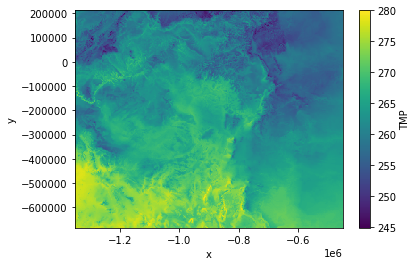

In [24]:
data.TMP.plot()

Finishing it off to get data at different times:

In [31]:
start = datetime.datetime(2018, 1, 1, 0)
times = [start + datetime.timedelta(weeks=week_delta) for week_delta in range(2)]

zarr_ids = [dataclasses.replace(zarr_id, run_hour=time) for time in times]

def get_data(zarr_ids, chunk_ids, is_forecast):
    datasets = []
    for zarr_id in zarr_ids:
        data = get_chunks_combined(zarr_id, chunk_ids)
        new_time_dimension = "run_time" if is_forecast else "time"
        data[new_time_dimension] = zarr_id.run_hour
        datasets.append(data)
    ds = xr.concat(datasets, dim=new_time_dimension, combine_attrs="override")
    return ds
    
get_data(zarr_ids, chunk_ids, False)

<xarray.Dataset>
Dimensions:     (time: 2, x: 300, y: 300)
Coordinates:
  * x           (x) float64 -1.35e+06 -1.347e+06 ... -4.543e+05 -4.512e+05
  * y           (y) float64 -6.838e+05 -6.808e+05 ... 2.082e+05 2.112e+05
  * time        (time) datetime64[ns] 2018-01-01 2018-01-08
Data variables:
    chunk_id    (time, x, y) object '2.3' '2.3' '2.3' ... '3.4' '3.4' '3.4'
    index_x     (time, x, y) float64 450.0 450.0 450.0 ... 749.0 749.0 749.0
    chunk_x     (time, x, y) float64 3.0 3.0 3.0 3.0 3.0 ... 4.0 4.0 4.0 4.0 4.0
    in_chunk_x  (time, x, y) float64 0.0 0.0 0.0 0.0 ... 149.0 149.0 149.0 149.0
    latitude    (time, y, x) float64 31.4 31.41 31.41 ... 40.27 40.27 40.27
    longitude   (time, y, x) float64 -111.6 -111.6 -111.6 ... -102.8 -102.8
    index_y     (time, y, x) float64 300.0 300.0 300.0 ... 599.0 599.0 599.0
    chunk_y     (time, y, x) float64 2.0 2.0 2.0 2.0 2.0 ... 3.0 3.0 3.0 3.0 3.0
    in_chunk_y  (time, y, x) float64 0.0 0.0 0.0 0.0 ... 149.0 149.0 149.0 149.0
    TMP         (time, y, x) float16 303.0 303.5 303.8 ... 288.5 288.5 288.2

### Misc. Use Cases

- I'm only looking at a grid point or small area and only during one model run
    - Just load the whole grid, it's easier
- I'm looking at the gridpoint/small area at one time, but for tons of variables
    - Looking up by chunk will be faster

## Troubleshooting

In my Jupyter notebook setup, the pyproj package gives the following error when it tries looking up the projection info:

```
CRSError: Invalid datum string: urn:ogc:def:datum:EPSG::6326: (Internal Proj Error: proj_create: SQLite error on SELECT name, ellipsoid_auth_name, ellipsoid_code, prime_meridian_auth_name, prime_meridian_code, publication_date, frame_reference_epoch, deprecated FROM geodetic_datum WHERE auth_name = ? AND code = ?: no such column: publication_date)
```

I believe this is because I run Jupyter from a conda environment that's different than the kernel Jupyter is using. In any case, there's an easy fix:

In [8]:
import pyproj
pyproj.datadir.set_data_dir("/Users/<me>/.conda/envs/<this notebook's kernel env>/share/proj")